In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os 
from pathlib import Path
import subprocess
from sleepecg import compare_heartbeats

DatasetPath = "C:/Users/ARTAPC/Desktop/EcgSamples"  # Path to the MIT-BIH directory.

os.chdir("C:/Users/ARTAPC/Desktop/EcgSamples")

EpisodeNames = []

for file in os.listdir(DatasetPath):
    if file.endswith(".dat"):
        
        EpisodeNames.append( Path((file)).stem )

In [2]:
BlackList = [102,104,113,108,207] # Records with PaceMakers/Considerable Noise

EpisodeNames[:] = [item for item in EpisodeNames if int(item) not in BlackList]


In [3]:
signal = []
actualpeaks = []


for ep in EpisodeNames:

    signals, fields= wfdb.rdsamp(ep)
    signal.append(signals[:,0])
    Annotations= wfdb.rdann(ep,'atr', return_label_elements=['symbol'])
    PeakSamples=Annotations.sample
    PeakSymbols=Annotations.symbol
    RealPeaksIndex=[]
    for index, sym in enumerate(PeakSymbols):
        if sym == 'N' or sym == 'V' or sym=='A':
            RealPeaksIndex=np.append(RealPeaksIndex, index)
    RealPeaksIndex= RealPeaksIndex.astype(int)
    RealPeaks=PeakSamples[RealPeaksIndex]

    actualpeaks.append(np.array([peak for peak in RealPeaks if peak < 500000]) )  

In [4]:
Exefile_Path = "C:/Users/ARTAPC/Desktop/test_alg/src"   # Path to where PanTompkins.exe is located.

os.chdir(Exefile_Path)

output=[]

for ep in signal:
        
    with open('ecg.txt', 'w') as f:
        for line in ep:
            f.write(f"{line}\n")


    open("output.txt", "w").close() # Clears output.txt after each Episode.

    subprocess.call(r"PanTompkins.exe", stdin=None, stdout=None, stderr=None, shell=False) # Calls PanTompkins.exe to write in output.txt

    with open('output.txt') as file:
        lines = np.array([line.rstrip() for line in file]) 
    
    output.append(np.array([int (l) for l in lines])) 

<BarContainer object of 43 artists>

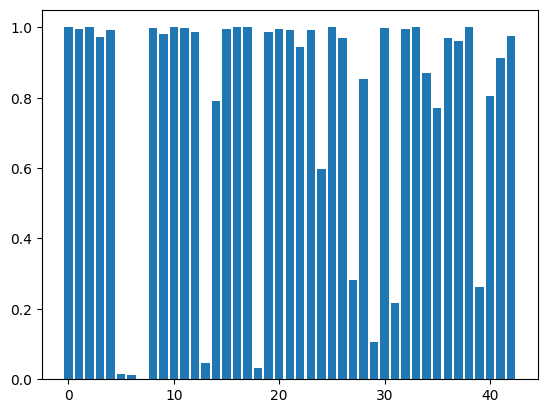

In [5]:
TruePositiveRate_recall=[]
PositivePredictiveValue_precision = []

for i,ep in enumerate(output):

    res = compare_heartbeats(ep,actualpeaks[i],max_distance=7)

    TruePositiveRate_recall.append(len(res.TP)/(len(res.TP)+len(res.FN)))    # Recall 
    PositivePredictiveValue_precision.append(len(res.TP)/(len(res.TP)+len(res.FP)))  # Accuracy

PositivePredictiveValue_precision
plt.bar(range(len(PositivePredictiveValue_precision)),PositivePredictiveValue_precision)

# Accuracy with other methods

## WFDB Processing

<BarContainer object of 43 artists>

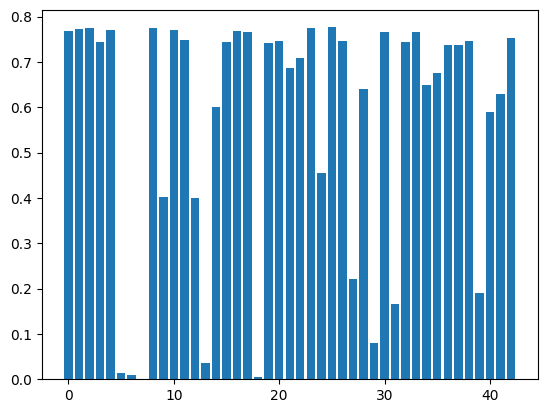

In [6]:
import wfdb.processing

peaks = []

res = []

for ep in signal:

    peaks.append ( wfdb.processing.xqrs_detect(ep, fs=360, verbose=False) )


precision = []

for i,ep in enumerate(signal):

    res =    compare_heartbeats (  peaks[i] , actualpeaks[i]  ,  max_distance=7 )    

    precision.append (len(res.TP)/(len(res.TP)+len(res.FP)))


plt.bar(range(len(precision)),precision)     

## Neurokit  

<BarContainer object of 43 artists>

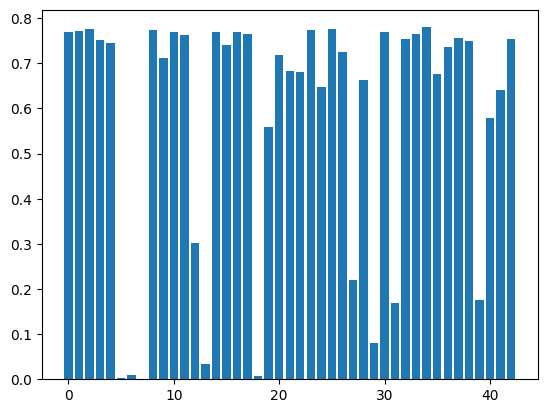

In [7]:
import neurokit2  # pip install neurokit2

peaks=[] 


for ep in signal:


    _, results = neurokit2.ecg_peaks(ep, sampling_rate=360)

    peaks.append ( results )

precision = []

for i,ep in enumerate(signal):

    res =  compare_heartbeats ( peaks[i]["ECG_R_Peaks"] , actualpeaks[i]  ,  max_distance=7 )    

    precision.append (len(res.TP)/(len(res.TP)+len(res.FP)))


plt.bar(range(len(precision)),precision)     



## Sleepecg  

<BarContainer object of 43 artists>

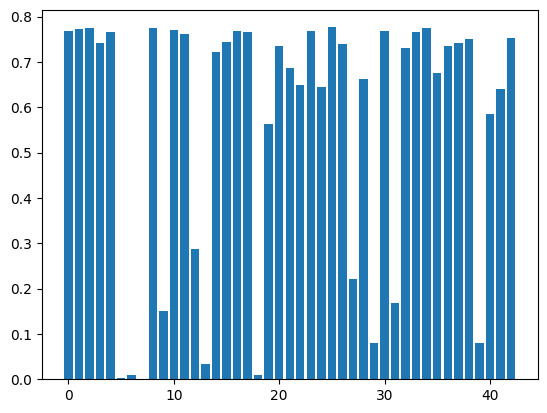

In [8]:
import sleepecg  

peaks=[] 


for ep in signal:
    
    
    peaks.append ( sleepecg.detect_heartbeats(ep, fs=360) )

precision = []

for i,ep in enumerate(signal):

    res =  compare_heartbeats ( peaks[i] , actualpeaks[i]  ,  max_distance=7 )    

    precision.append (len(res.TP)/(len(res.TP)+len(res.FP)))


plt.bar(range(len(precision)),precision)     
